
# 📊 دفتر مفاهيم تنقيب البيانات: Telco Customer Churn

**البيانات المستهدفة:** `telco_customer_churn.csv`

في هذا الدفتر نطبّق مفاهيم أساسية في تنقيب البيانات باستخدام بيانات **Telco Customer Churn**، وتشمل:
- الافتراضات (Hypotheses) مع رسومات
- الاستكشاف والتنظيف (EDA & Preprocessing)
- التصنيف (Classification)
- التجميع (Clustering)
- قواعد الارتباط (Association Rules)
- التنبؤ (Regression)
- تقليل الأبعاد (PCA)


## 1) تحميل المكتبات والبيانات

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# عرض كل الأعمدة عند الطباعة
pd.set_option('display.max_columns', None)

# تحميل بيانات Telco
df = pd.read_csv("telco_customer_churn.csv")
print("شكل البيانات (صفوف, أعمدة):", df.shape)
df.head()


شكل البيانات (صفوف, أعمدة): (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



## 2) الافتراضات في تنقيب البيانات (Hypotheses)

سنضع فرضيات مبنية على بيانات **Telco** لاختبارها لاحقًا:
1. العملاء ذوو مدة اشتراك أطول (**tenure**) أقل عرضة لترك الخدمة (**Churn**).
2. العملاء ذوو الفواتير الشهرية الأعلى (**MonthlyCharges**) أكثر عرضة للـ Churn.
3. نوع خدمة الإنترنت (**InternetService**) والخدمات الإضافية قد يؤثران على معدّل الـ Churn.


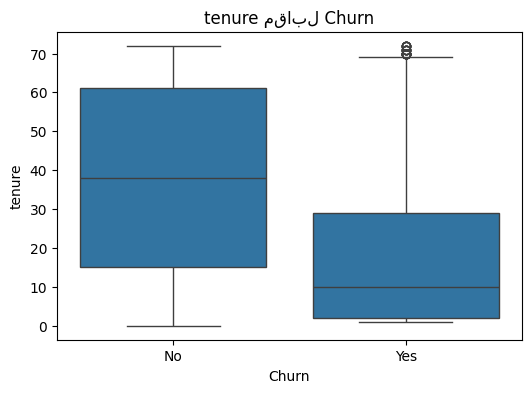

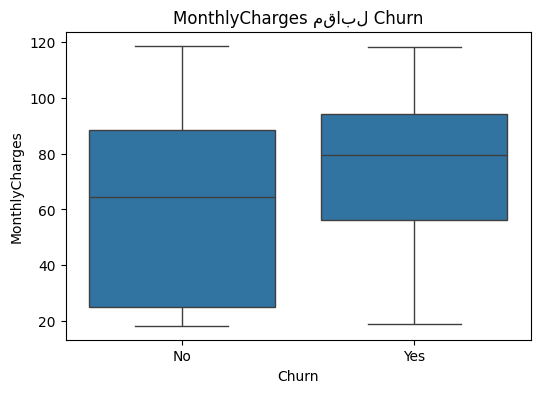

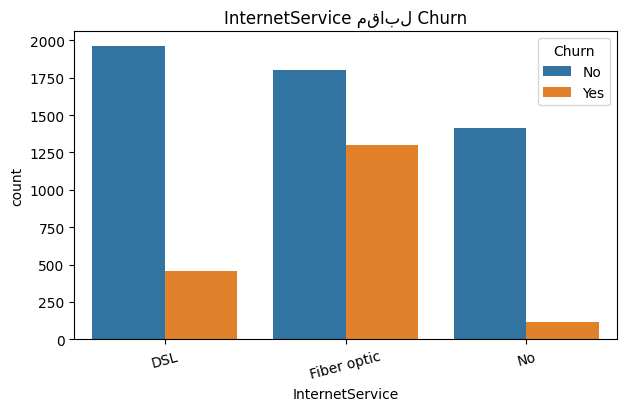

In [2]:

# رسومات لاختبار الفرضيات
fig = plt.figure(figsize=(6,4))
sns.boxplot(x="Churn", y="tenure", data=df)
plt.title("tenure مقابل Churn")
plt.show()

fig = plt.figure(figsize=(6,4))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("MonthlyCharges مقابل Churn")
plt.show()

fig = plt.figure(figsize=(7,4))
sns.countplot(x="InternetService", hue="Churn", data=df)
plt.title("InternetService مقابل Churn")
plt.xticks(rotation=15)
plt.show()


## 3) الاستكشاف والتنظيف (EDA & Preprocessing)

القيم المفقودة قبل التنظيف:
 TotalCharges    11
dtype: int64

بعد التنظيف:
 Series([], dtype: int64)

أنواع البيانات:
object     16
int64       3
float64     2
Name: count, dtype: int64

توزيع Churn:
Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64


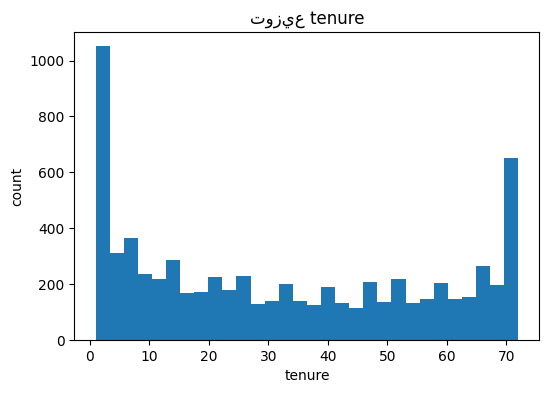

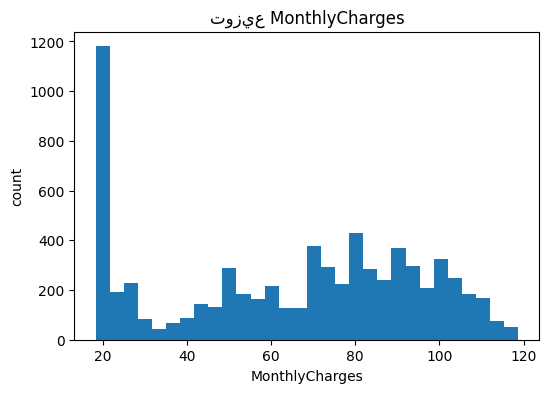

In [3]:

# تحويل TotalCharges إلى رقم والتعامل مع القيم المفقودة
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
missing_before = df.isna().sum()
df = df.dropna()
missing_after = df.isna().sum()

print("القيم المفقودة قبل التنظيف:\n", missing_before[missing_before>0])
print("\nبعد التنظيف:\n", missing_after[missing_after>0])

# تحويل Churn إلى 0/1
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

# لمحة عامة
print("\nأنواع البيانات:")
print(df.dtypes.value_counts())
print("\nتوزيع Churn:")
print(df['Churn'].value_counts(normalize=True).rename({0:"No",1:"Yes"}))

# بعض الرسومات الاستكشافية
fig = plt.figure(figsize=(6,4))
plt.hist(df['tenure'], bins=30)
plt.title("توزيع tenure")
plt.xlabel("tenure")
plt.ylabel("count")
plt.show()

fig = plt.figure(figsize=(6,4))
plt.hist(df['MonthlyCharges'], bins=30)
plt.title("توزيع MonthlyCharges")
plt.xlabel("MonthlyCharges")
plt.ylabel("count")
plt.show()


## 4) التصنيف (Classification: Logistic Regression)

In [4]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# ترميز الأعمدة النصية (باستثناء customerID)
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col != 'customerID':
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

X = df_encoded.drop(columns=['customerID','Churn'])
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=2000, n_jobs=None)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1549
           1       0.64      0.56      0.60       561

    accuracy                           0.80      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.79      0.80      0.80      2110

Confusion Matrix:
 [[1373  176]
 [ 245  316]]


## 5) التجميع (Clustering: KMeans)

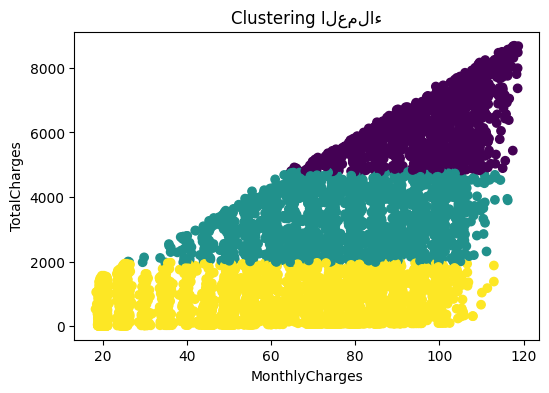

In [5]:

from sklearn.cluster import KMeans

X_cluster = df[['tenure','MonthlyCharges','TotalCharges']].copy()
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_cluster)

fig = plt.figure(figsize=(6,4))
plt.scatter(df['MonthlyCharges'], df['TotalCharges'], c=df['Cluster'])
plt.xlabel("MonthlyCharges")
plt.ylabel("TotalCharges")
plt.title("Clustering العملاء")
plt.show()



## 6) قواعد الارتباط (Association Rules)

> ملاحظة: إذا لم تكن حزمة **mlxtend** مثبتة لديك، ستظهر رسالة توضيحية بدل الخطأ.


In [6]:

try:
    from mlxtend.frequent_patterns import apriori, association_rules
    # تجهيز بيانات الخدمات كثنائية
    services = ['PhoneService','InternetService','OnlineSecurity','OnlineBackup',
                'TechSupport','StreamingTV','StreamingMovies']

    df_rules = df[services].copy()
    # تحويل إلى 1/0 (واعتبار DSL أو Fiber optic كـ 1 لخدمة الإنترنت)
    for col in services:
        df_rules[col] = df_rules[col].replace({'Yes':1, 'No':0, 'DSL':1, 'Fiber optic':1})
    df_rules = df_rules.astype(int)

    freq = apriori(df_rules, min_support=0.3, use_colnames=True)
    rules = association_rules(freq, metric="lift", min_threshold=1.0)
    print(rules.head(10))
except Exception as e:
    print("لم يتم تنفيذ قسم قواعد الارتباط. سبب ذلك:", e)
    print("يمكنك تثبيت mlxtend عبر: !pip install mlxtend (ثم أعد تشغيل الخلية)")


لم يتم تنفيذ قسم قواعد الارتباط. سبب ذلك: invalid literal for int() with base 10: 'No internet service'
يمكنك تثبيت mlxtend عبر: !pip install mlxtend (ثم أعد تشغيل الخلية)


/tmp/ipykernel_33302/1600274758.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_rules[col] = df_rules[col].replace({'Yes':1, 'No':0, 'DSL':1, 'Fiber optic':1})


## 7) التنبؤ (Regression: Linear Regression)

R^2: 0.69
MAE: 13.0267
المعاملات: {'tenure': np.float64(-1.1213227376773252), 'TotalCharges': np.float64(0.018669177509571585)}
الانحراف: 58.526152926496884


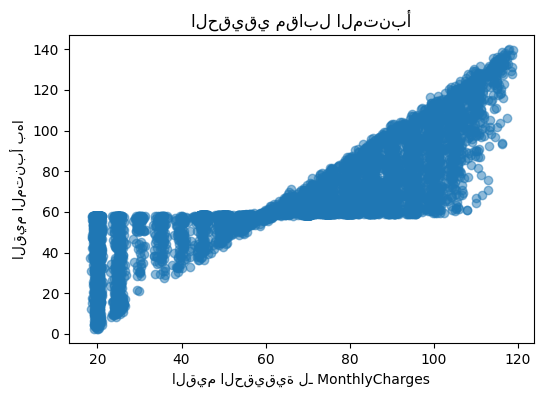

In [7]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

X_reg = df[['tenure','TotalCharges']]
y_reg = df['MonthlyCharges']

reg = LinearRegression()
reg.fit(X_reg, y_reg)
pred = reg.predict(X_reg)

print("R^2:", round(r2_score(y_reg, pred), 4))
print("MAE:", round(mean_absolute_error(y_reg, pred), 4))
print("المعاملات:", dict(zip(X_reg.columns, reg.coef_)))
print("الانحراف:", reg.intercept_)

fig = plt.figure(figsize=(6,4))
plt.scatter(y_reg, pred, alpha=0.5)
plt.xlabel("القيم الحقيقية لـ MonthlyCharges")
plt.ylabel("القيم المتنبأ بها")
plt.title("الحقيقي مقابل المتنبأ")
plt.show()


## 8) تقليل الأبعاد (PCA)

النسبة المفسرة من التباين لكل مكون: [0.72659927 0.25358707]


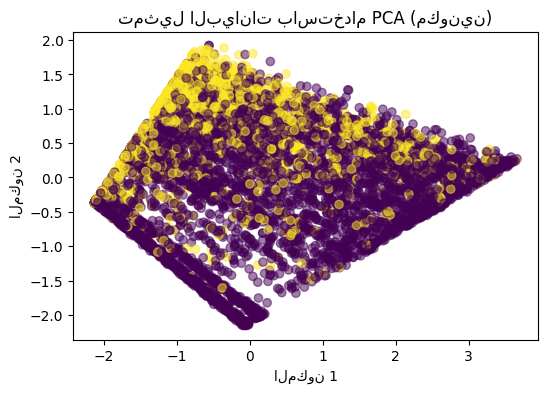

In [8]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = ['tenure','MonthlyCharges','TotalCharges']
X_pca_in = df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca_in)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("النسبة المفسرة من التباين لكل مكون:", pca.explained_variance_ratio_)

fig = plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5, c=df['Churn'])
plt.xlabel("المكون 1")
plt.ylabel("المكون 2")
plt.title("تمثيل البيانات باستخدام PCA (مكونين)")
plt.show()


In [ ]:
## 🌳 التصنيف باستخدام Random Forest

خوارزمية **Random Forest** هي إحدى طرق التعلم الآلي التجميعية (Ensemble Learning)، 
تعتمد على تدريب عدة أشجار قرار ودمج نتائجها لزيادة الدقة وتقليل مشكلة الـ Overfitting.  
سنستخدمها هنا للتنبؤ بترك العميل للخدمة (`Churn`) بالاعتماد على بعض الخصائص الديموغرافية والفواتير.


🎯 الدقة: 0.79478672985782

📊 تقرير التصنيف:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1549
           1       0.65      0.49      0.56       561

    accuracy                           0.79      2110
   macro avg       0.74      0.70      0.71      2110
weighted avg       0.78      0.79      0.78      2110



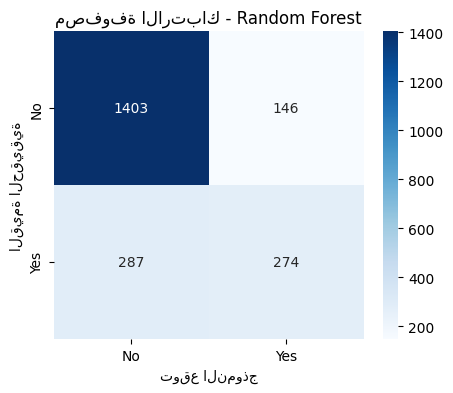

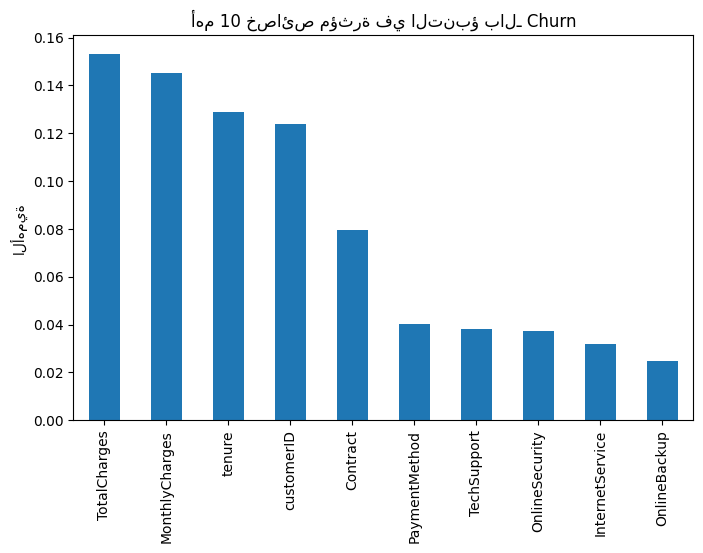

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# تجهيز البيانات
df_rf = df.copy()

# تحويل القيم النصية إلى رقمية
for col in df_rf.select_dtypes(include="object").columns:
    df_rf[col] = LabelEncoder().fit_transform(df_rf[col].astype(str))

# اختيار الخصائص والمتغير الهدف
X = df_rf.drop("Churn", axis=1)
y = df_rf["Churn"]

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# بناء النموذج
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# التنبؤ
y_pred = rf.predict(X_test)

# التقييم
print("🎯 الدقة:", accuracy_score(y_test, y_pred))
print("\n📊 تقرير التصنيف:\n", classification_report(y_test, y_pred))

# مصفوفة الارتباك
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("مصفوفة الارتباك - Random Forest")
plt.xlabel("توقع النموذج")
plt.ylabel("القيمة الحقيقية")
plt.show()

# أهمية الخصائص
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
importances.head(10).plot(kind="bar")
plt.title("أهم 10 خصائص مؤثرة في التنبؤ بالـ Churn")
plt.ylabel("الأهمية")
plt.show()



## 9) خاتمة
بهذا الدفتر نفذنا دورة مصغّرة لمفاهيم تنقيب البيانات على **Telco Customer Churn** مع رسومات وقياسات تقييم.
